In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from model import TDRLSGalerkinSARIMA
import time

In [2]:
np.random.seed(123)
n = 300
t = np.arange(n)

# A: Noisy ARMA(2,1)
phi_true = [0.6, -0.3]
theta_true = [0.5]
eps = np.random.normal(scale=1.0, size=n)
y_a = np.zeros(n)
for i in range(2, n):
    y_a[i] = (phi_true[0] * y_a[i-1] + phi_true[1] * y_a[i-2] + theta_true[0] * eps[i-1] + eps[i])

# B: Seasonal sine + noise (period m=20)
y_b = np.sin(2 * np.pi * t / 20) + 0.5 * np.random.normal(size=n)

# C: Linear trend + AR(1)
eps_c = np.random.normal(scale=0.5, size=n)
y_c = np.zeros(n)
for i in range(1, n):
    y_c[i] = 0.01 * i + 0.8 * y_c[i-1] + eps_c[i]

# D: Nonlinear (Logistic map) + noise
r = 3.8
eps_d = np.random.normal(scale=0.02, size=n)
y_d = np.zeros(n)
y_d[0] = 0.4
for i in range(1, n):
    y_d[i] = r * y_d[i-1] * (1 - y_d[i-1]) + eps_d[i]

datasets = {
    'Noisy_ARMA': y_a,
    'Seasonal': y_b,
    'Trend_AR': y_c,
    'Nonlinear': y_d
}



In [3]:
window = 15
horizon = 250
num_runs = 1
p_values = [1]
q_values = [1]
P_values = [1]
Q_values = [1]
m_seasonal = 5
orders = [(p, q, P, Q) for p in p_values for q in q_values for P in P_values for Q in Q_values]
forecast_steps = 1  # Add missing forecast_steps definition

In [4]:
def td_forecast_k_steps(model: TDRLSGalerkinSARIMA, y_hist: np.ndarray, steps: int) -> np.ndarray:
    y_hist_work = np.asarray(y_hist, dtype=float).copy()
    out = []
    for _ in range(steps):
        t_last = len(y_hist_work) - 1
        phi_raw = model._build_phi(y_hist_work, t_last + 1)   # uses predicted history
        psi_raw = model._build_psi()                          # keeps past eps history frozen
        phi = model._scale_phi(phi_raw)
        psi = model._scale_psi(psi_raw)
        yhat = float(phi @ model.beta) + float(psi @ model.alpha)
        if not np.isfinite(yhat):
            yhat = y_hist_work[-1]
        out.append(yhat)
        y_hist_work = np.append(y_hist_work, yhat)
    return np.array(out, dtype=float)


In [5]:
import time
from statsmodels.tsa.arima.model import ARIMA
from model import GalerkinSARIMA

# Define algorithms to run - now including TD-Ridge!
algorithms = [
    {'name': 'TD-Galerkin-OLS', 'is_td': True, 'use_ridge': False},
    {'name': 'TD-Galerkin-Ridge', 'is_td': True, 'use_ridge': True, 'ridge_lambda_ar': 1.5, 'ridge_lambda_ma': 1.0,
     'ridge_weight_scheme': 'poly', 'ridge_eta': 1.5},
    {'name': 'GARIMA-OLS', 'use_ridge': False},
    {'name': 'GARIMA-Ridge', 'use_ridge': True, 'ridge_lambda_ar': 1.5, 'ridge_lambda_ma': 1.0, 
     'ridge_weight_scheme': 'poly', 'ridge_eta': 1.5},
    {'name': 'ARIMA', 'is_statsmodels': True},
]

all_results = []
first_run_preds = {}

for run in range(1, num_runs + 1):
    runs_left = num_runs - run
    print(f"\n=== Run {run}/{num_runs}  (runs left after this: {runs_left}) ===")

    for name, series in datasets.items():
        m = m_seasonal

        for p, q, P, Q in tqdm(orders, desc=f"Param combos for {name}", total=len(orders), leave=False):
            y_true = series[window:window + horizon]
            
            # Run each algorithm
            for alg_config in algorithms:
                alg_name = alg_config['name']
                preds = []
                iter_times = []
                
                combo_start = time.perf_counter()
                
                for i in range(window, window + horizon):
                    t0 = time.perf_counter()
                    train = series[:i]
                    
                    try:
                        if alg_config.get('is_td', False):
                            # TD-Galerkin-SARIMA (OLS or Ridge)
                            model_td = TDRLSGalerkinSARIMA(
                                order=(p, 0, q),
                                seasonal_order=(P, 0, Q, m),
                                basis_functions=["linear", "quadratic"],
                                rho=0.9999,
                                lambda_beta=alg_config.get('ridge_lambda_ar', 1e-1),
                                lambda_alpha=alg_config.get('ridge_lambda_ma', 1e-1),
                                use_ridge=alg_config.get('use_ridge', False),
                                ridge_weight_scheme=alg_config.get('ridge_weight_scheme', 'none'),
                                ridge_eta=alg_config.get('ridge_eta', 1.0),
                                standardize=False
                            )
                            model_td.fit(train)
                            pred_vec = td_forecast_k_steps(model_td, train, steps=forecast_steps)
                            pred = pred_vec[-1] if np.ndim(pred_vec) > 0 else float(pred_vec)
                            
                        elif alg_config.get('is_statsmodels', False):
                            # ARIMA from statsmodels
                            model = ARIMA(train, order=(p, 0, q), seasonal_order=(P, 0, Q, m))
                            model_fit = model.fit(method_kwargs={"warn_convergence": False})
                            pred_vec = model_fit.forecast(steps=forecast_steps)
                            pred = float(pred_vec[-1])
                            
                        else:
                            # GalerkinSARIMA (OLS or Ridge)
                            model = GalerkinSARIMA(
                                train,
                                order=(p, 0, q),
                                seasonal_order=(P, 0, Q, m),
                                basis_functions=["linear", "quadratic"],
                                forecast_method="direct",
                                use_ridge=alg_config['use_ridge'],
                                ridge_lambda_ar=alg_config.get('ridge_lambda_ar', 1.0),
                                ridge_lambda_ma=alg_config.get('ridge_lambda_ma', 1.0),
                                ridge_weight_scheme=alg_config.get('ridge_weight_scheme', 'none'),
                                ridge_eta=alg_config.get('ridge_eta', 1.0),
                                standardize=True
                            )
                            model.fit(train)
                            pred_vec = model.forecast(steps=forecast_steps)
                            pred = pred_vec[-1] if np.ndim(pred_vec) > 0 else float(pred_vec)
                        
                        preds.append(float(pred))
                    except Exception as e:
                        # If fitting fails, use last value
                        preds.append(float(train[-1]))
                    
                    iter_times.append(time.perf_counter() - t0)
                
                combo_sec = time.perf_counter() - combo_start
                
                preds = np.asarray(preds, dtype=float)
                
                # Store predictions from first run for plotting
                if run == 1:
                    first_run_preds[(name, p, q, P, Q, alg_name)] = preds
                
                # Calculate metrics
                mask = np.isfinite(y_true) & np.isfinite(preds)
                mae = mean_absolute_error(y_true[mask], preds[mask]) if mask.any() else np.nan
                rmse = np.sqrt(mean_squared_error(y_true[mask], preds[mask])) if mask.any() else np.nan
                
                # Timing stats
                mean_iter_ms = float(np.mean(iter_times)) * 1000 if len(iter_times) else np.nan
                median_iter_ms = float(np.median(iter_times)) * 1000 if len(iter_times) else np.nan
                max_iter_ms = float(np.max(iter_times)) * 1000 if len(iter_times) else np.nan
                throughput = (len(iter_times) / combo_sec) if combo_sec > 0 else np.nan
                
                all_results.append([
                    name, p, q, P, Q, run, alg_name,
                    mae, rmse,
                    mean_iter_ms, median_iter_ms, max_iter_ms,
                    combo_sec, len(iter_times), throughput
                ])

# Aggregate and print (timing included)
df = pd.DataFrame(
    all_results,
    columns=[
        'Dataset', 'p', 'q', 'P', 'Q', 'Run', 'Alg',
        'MAE', 'RMSE',
        'mean_iter_ms', 'median_iter_ms', 'max_iter_ms',
        'combo_sec', 'num_iters', 'throughput_iters_per_sec'
    ]
)
agg = df.groupby(['Dataset', 'p', 'q', 'P', 'Q', 'Alg'], as_index=False).mean(numeric_only=True)

print("\nAveraged over {} runs (including timing):\n".format(num_runs))
try:
    print(agg.to_markdown(index=False, floatfmt=".4f"))
except Exception:
    print(agg)
results = agg


=== Run 1/1  (runs left after this: 0) ===


Param combos for Noisy_ARMA:   0%|          | 0/1 [00:00<?, ?it/s]/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.11/site-


Averaged over 1 runs (including timing):

| Dataset    |   p |   q |   P |   Q | Alg               |    Run |    MAE |   RMSE |   mean_iter_ms |   median_iter_ms |   max_iter_ms |   combo_sec |   num_iters |   throughput_iters_per_sec |
|:-----------|----:|----:|----:|----:|:------------------|-------:|-------:|-------:|---------------:|-----------------:|--------------:|------------:|------------:|---------------------------:|
| Noisy_ARMA |   1 |   1 |   1 |   1 | ARIMA             | 1.0000 | 0.8433 | 1.1027 |        62.9956 |          62.2199 |      120.6168 |     15.7490 |    250.0000 |                    15.8740 |
| Noisy_ARMA |   1 |   1 |   1 |   1 | GARIMA-OLS        | 1.0000 | 1.0992 | 1.9781 |         1.0721 |           1.0850 |        2.1061 |      0.2681 |    250.0000 |                   932.5975 |
| Noisy_ARMA |   1 |   1 |   1 |   1 | GARIMA-Ridge      | 1.0000 | 0.9620 | 1.2255 |         1.5596 |           1.5484 |        2.9798 |      0.3899 |    250.0000 |            

Showing plots for all parameter combinations...



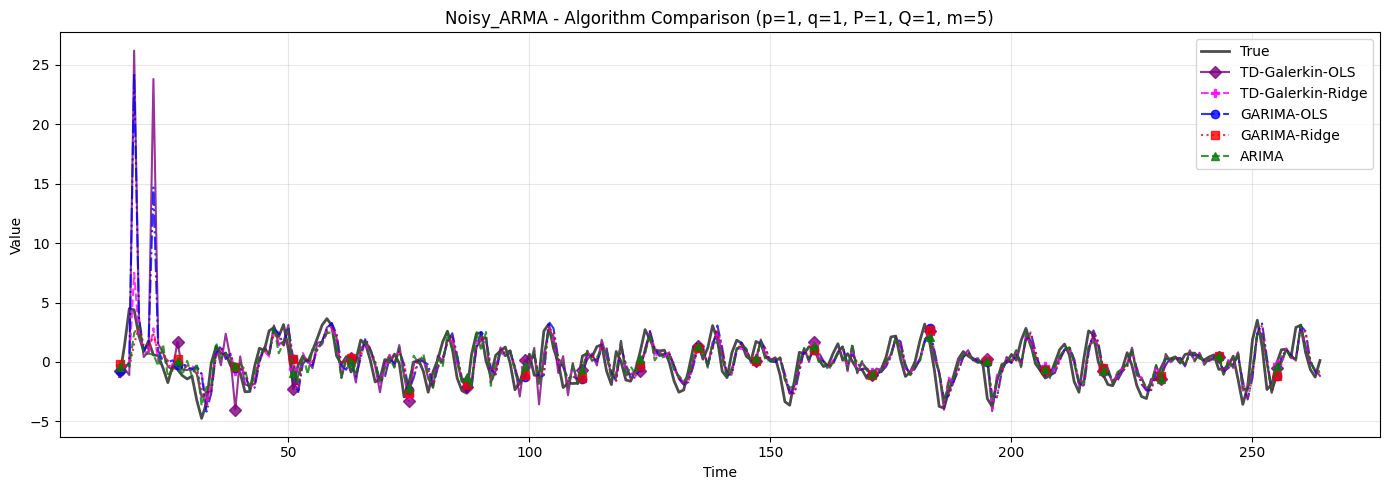


Noisy_ARMA (p=1, q=1, P=1, Q=1):
  ARIMA                - MAE: 0.8433, RMSE: 1.1027, Time: 15.75s
  GARIMA-OLS           - MAE: 1.0992, RMSE: 1.9781, Time: 0.27s
  GARIMA-Ridge         - MAE: 0.9620, RMSE: 1.2255, Time: 0.39s
  TD-Galerkin-OLS      - MAE: 1.0934, RMSE: 2.3281, Time: 0.91s
  TD-Galerkin-Ridge    - MAE: 0.8717, RMSE: 1.1366, Time: 0.92s



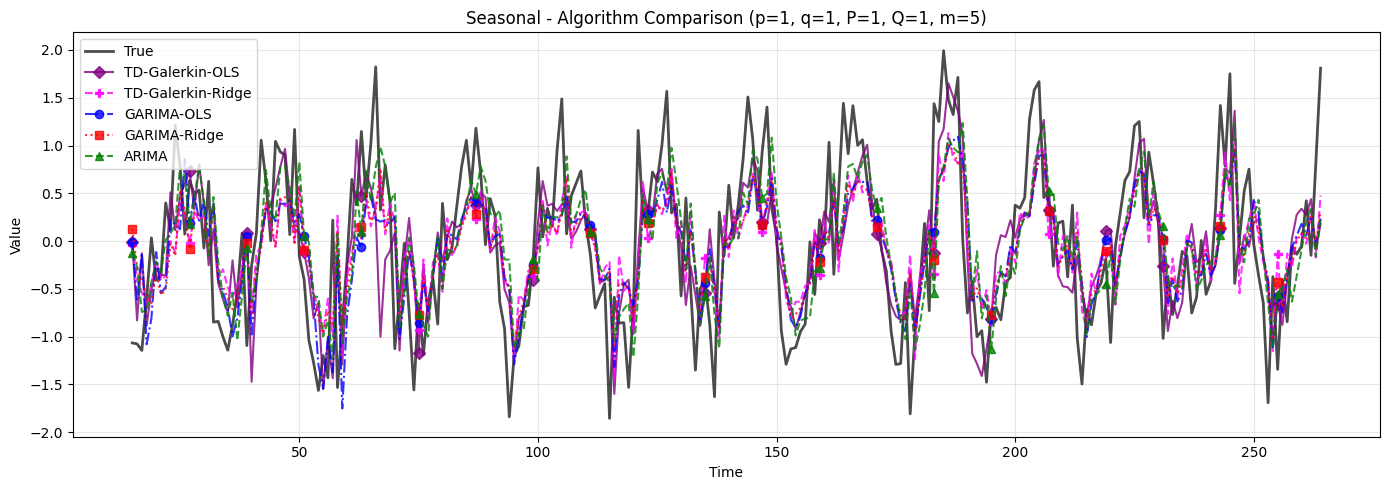


Seasonal (p=1, q=1, P=1, Q=1):
  ARIMA                - MAE: 0.5411, RMSE: 0.6779, Time: 14.61s
  GARIMA-OLS           - MAE: 0.5374, RMSE: 0.6588, Time: 0.27s
  GARIMA-Ridge         - MAE: 0.5367, RMSE: 0.6610, Time: 0.39s
  TD-Galerkin-OLS      - MAE: 0.5366, RMSE: 0.6597, Time: 0.92s
  TD-Galerkin-Ridge    - MAE: 0.5652, RMSE: 0.6856, Time: 0.92s



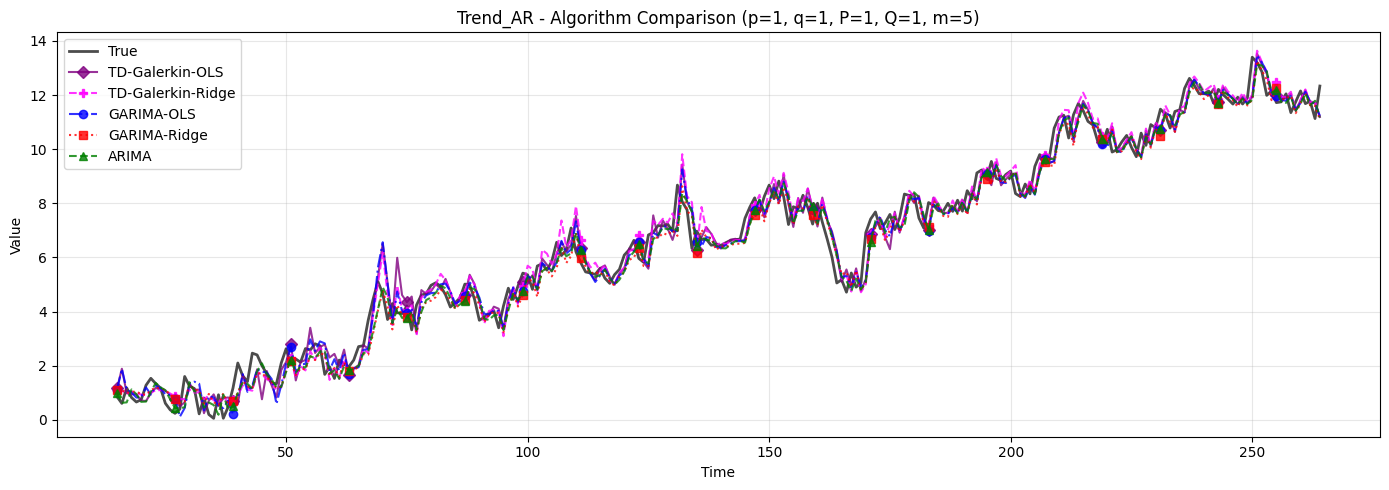


Trend_AR (p=1, q=1, P=1, Q=1):
  ARIMA                - MAE: 0.4371, RMSE: 0.5506, Time: 24.27s
  GARIMA-OLS           - MAE: 0.4575, RMSE: 0.5829, Time: 0.27s
  GARIMA-Ridge         - MAE: 0.4551, RMSE: 0.5728, Time: 0.39s
  TD-Galerkin-OLS      - MAE: 0.4858, RMSE: 0.6181, Time: 0.92s
  TD-Galerkin-Ridge    - MAE: 0.4868, RMSE: 0.6094, Time: 0.92s



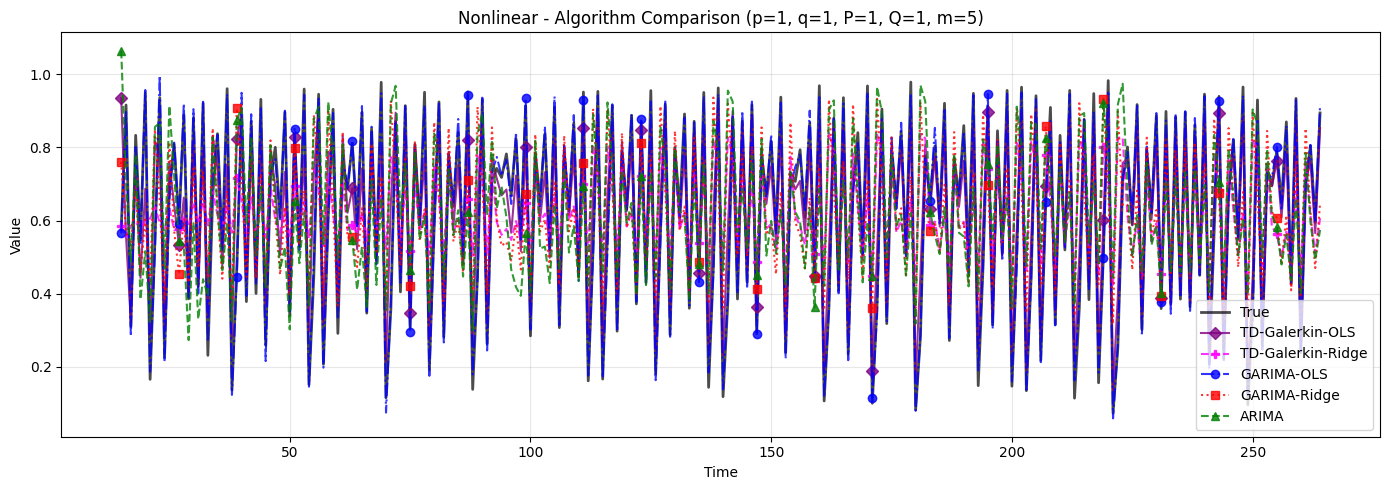


Nonlinear (p=1, q=1, P=1, Q=1):
  ARIMA                - MAE: 0.1939, RMSE: 0.2351, Time: 24.29s
  GARIMA-OLS           - MAE: 0.0167, RMSE: 0.0211, Time: 0.27s
  GARIMA-Ridge         - MAE: 0.1822, RMSE: 0.2182, Time: 0.39s
  TD-Galerkin-OLS      - MAE: 0.0719, RMSE: 0.0951, Time: 0.91s
  TD-Galerkin-Ridge    - MAE: 0.1993, RMSE: 0.2308, Time: 0.91s



In [6]:
# Plot comparison of all four algorithms
print("Showing plots for all parameter combinations...")
print()

for name, series in datasets.items():
    for p, q, P, Q in orders:
        y_true = series[window:window + horizon]
        
        plt.figure(figsize=(14, 5))
        plt.plot(range(window, window + horizon), y_true, 'k-', linewidth=2, label='True', alpha=0.7)
        
        # Plot each algorithm if it ran successfully
        colors = {'TD-Galerkin-OLS': 'purple', 'TD-Galerkin-Ridge': 'magenta', 
                  'GARIMA-OLS': 'blue', 'GARIMA-Ridge': 'red', 'ARIMA': 'green'}
        markers = {'TD-Galerkin-OLS': 'D', 'TD-Galerkin-Ridge': 'P',
                   'GARIMA-OLS': 'o', 'GARIMA-Ridge': 's', 'ARIMA': '^'}
        linestyles = {'TD-Galerkin-OLS': '-', 'TD-Galerkin-Ridge': '--',
                      'GARIMA-OLS': '-.', 'GARIMA-Ridge': ':', 'ARIMA': '--'}
        
        for alg_name in ['TD-Galerkin-OLS', 'TD-Galerkin-Ridge', 'GARIMA-OLS', 'GARIMA-Ridge', 'ARIMA']:
            key = (name, p, q, P, Q, alg_name)
            if key in first_run_preds:
                preds = first_run_preds[key]
                plt.plot(range(window, window + horizon), preds, 
                        color=colors[alg_name], 
                        linestyle=linestyles[alg_name],
                        marker=markers[alg_name],
                        markevery=max(1, horizon//20),  # Show markers at reasonable intervals
                        label=alg_name,
                        alpha=0.8)
        
        plt.title(f"{name} - Algorithm Comparison (p={p}, q={q}, P={P}, Q={Q}, m={m_seasonal})", fontsize=12)
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print error metrics for this parameter combo
        print(f"\n{name} (p={p}, q={q}, P={P}, Q={Q}):")
        subset = agg[(agg['Dataset'] == name) & 
                     (agg['p'] == p) & 
                     (agg['q'] == q) & 
                     (agg['P'] == P) & 
                     (agg['Q'] == Q)]
        if not subset.empty:
            for _, row in subset.iterrows():
                print(f"  {row['Alg']:20s} - MAE: {row['MAE']:.4f}, RMSE: {row['RMSE']:.4f}, Time: {row['combo_sec']:.2f}s")
        print()

SUMMARY: Algorithm Comparison for Synthetic Time Series

Overall Performance (averaged across all datasets):
              Alg      MAE     RMSE  combo_sec
            ARIMA 0.503855 0.641562  19.731205
TD-Galerkin-Ridge 0.530734 0.665597   0.919203
     GARIMA-Ridge 0.534024 0.669377   0.389819
       GARIMA-OLS 0.527703 0.810258   0.268513
  TD-Galerkin-OLS 0.546932 0.925234   0.917780

Best Algorithm for Each Dataset (by RMSE):

Noisy_ARMA:
  Best algorithm: ARIMA
  MAE: 0.8433, RMSE: 1.1027
  Time: 15.75s

Seasonal:
  Best algorithm: GARIMA-OLS
  MAE: 0.5374, RMSE: 0.6588
  Time: 0.27s

Trend_AR:
  Best algorithm: ARIMA
  MAE: 0.4371, RMSE: 0.5506
  Time: 24.27s

Nonlinear:
  Best algorithm: GARIMA-OLS
  MAE: 0.0167, RMSE: 0.0211
  Time: 0.27s

Top 10 Algorithm-Dataset Combinations by RMSE:

Rank 1: GARIMA-OLS on Nonlinear
  MAE: 0.0167, RMSE: 0.0211

Rank 2: TD-Galerkin-OLS on Nonlinear
  MAE: 0.0719, RMSE: 0.0951

Rank 3: GARIMA-Ridge on Nonlinear
  MAE: 0.1822, RMSE: 0.2182

Ran

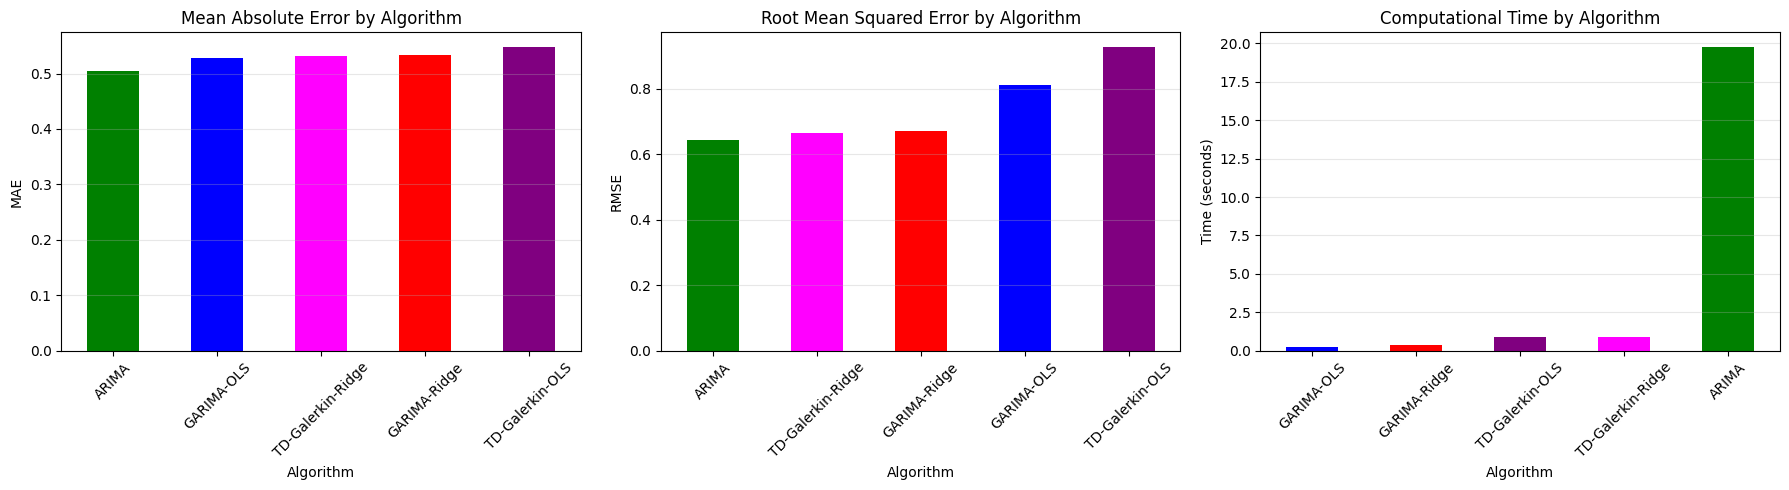


Performance by Dataset Type:
Alg            ARIMA  GARIMA-OLS  GARIMA-Ridge  TD-Galerkin-OLS  \
Dataset                                                           
Noisy_ARMA  1.102725    1.978127      1.225543         2.328077   
Nonlinear   0.235085    0.021142      0.218159         0.095108   
Seasonal    0.677856    0.658837      0.661020         0.659673   
Trend_AR    0.550583    0.582927      0.572785         0.618076   

Alg         TD-Galerkin-Ridge  
Dataset                        
Noisy_ARMA           1.136623  
Nonlinear            0.230823  
Seasonal             0.685581  
Trend_AR             0.609362  

Statistical Summary:
                    MAE                                                  \
                  count    mean     std     min     25%     50%     75%   
Alg                                                                       
ARIMA               4.0  0.5039  0.2691  0.1939  0.3763  0.4891  0.6167   
GARIMA-OLS          4.0  0.5277  0.4445  0.0167  0.34

In [7]:
# Summary comparison across all algorithms
print("="*80)
print("SUMMARY: Algorithm Comparison for Synthetic Time Series")
print("="*80)

# Overall average performance
overall = df.groupby('Alg', as_index=False)[['MAE', 'RMSE', 'combo_sec']].mean()
overall = overall.sort_values('RMSE')

print("\nOverall Performance (averaged across all datasets):")
print(overall.to_string(index=False))

# Best algorithm per dataset
print("\n" + "="*80)
print("Best Algorithm for Each Dataset (by RMSE):")
print("="*80)

for dataset in df['Dataset'].unique():
    dataset_df = df[df['Dataset'] == dataset]
    best = dataset_df.loc[dataset_df['RMSE'].idxmin()]
    
    print(f"\n{dataset}:")
    print(f"  Best algorithm: {best['Alg']}")
    print(f"  MAE: {best['MAE']:.4f}, RMSE: {best['RMSE']:.4f}")
    print(f"  Time: {best['combo_sec']:.2f}s")

# Show top 10 algorithm-dataset combinations
print("\n" + "="*80)
print("Top 10 Algorithm-Dataset Combinations by RMSE:")
print("="*80)

top10 = df.sort_values('RMSE').head(10)
for idx, row in top10.iterrows():
    print(f"\nRank {list(top10.index).index(idx)+1}: {row['Alg']} on {row['Dataset']}")
    print(f"  MAE: {row['MAE']:.4f}, RMSE: {row['RMSE']:.4f}")

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE by algorithm
mae_by_alg = df.groupby('Alg')['MAE'].mean().sort_values()
alg_colors = [{'TD-Galerkin-OLS': 'purple', 'TD-Galerkin-Ridge': 'magenta', 
               'GARIMA-OLS': 'blue', 'GARIMA-Ridge': 'red', 'ARIMA': 'green'}[a] 
              for a in mae_by_alg.index]
mae_by_alg.plot(kind='bar', ax=axes[0], color=alg_colors)
axes[0].set_title('Mean Absolute Error by Algorithm', fontsize=12)
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Algorithm')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# RMSE by algorithm
rmse_by_alg = df.groupby('Alg')['RMSE'].mean().sort_values()
alg_colors = [{'TD-Galerkin-OLS': 'purple', 'TD-Galerkin-Ridge': 'magenta',
               'GARIMA-OLS': 'blue', 'GARIMA-Ridge': 'red', 'ARIMA': 'green'}[a]
              for a in rmse_by_alg.index]
rmse_by_alg.plot(kind='bar', ax=axes[1], color=alg_colors)
axes[1].set_title('Root Mean Squared Error by Algorithm', fontsize=12)
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Algorithm')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# Computational time by algorithm
time_by_alg = df.groupby('Alg')['combo_sec'].mean().sort_values()
alg_colors = [{'TD-Galerkin-OLS': 'purple', 'TD-Galerkin-Ridge': 'magenta',
               'GARIMA-OLS': 'blue', 'GARIMA-Ridge': 'red', 'ARIMA': 'green'}[a]
              for a in time_by_alg.index]
time_by_alg.plot(kind='bar', ax=axes[2], color=alg_colors)
axes[2].set_title('Computational Time by Algorithm', fontsize=12)
axes[2].set_ylabel('Time (seconds)')
axes[2].set_xlabel('Algorithm')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Performance by dataset type
print("\n" + "="*80)
print("Performance by Dataset Type:")
print("="*80)

dataset_perf = df.groupby(['Dataset', 'Alg'])['RMSE'].mean().unstack()
print(dataset_perf)

# Statistical summary
print("\n" + "="*80)
print("Statistical Summary:")
print("="*80)
print(df.groupby('Alg')[['MAE', 'RMSE', 'combo_sec', 'throughput_iters_per_sec']].describe().round(4))

# TD-specific analysis
print("\n" + "="*80)
print("Time-Dependent vs Time-Independent Analysis:")
print("="*80)

td_results = df[df['Alg'].isin(['TD-Galerkin-OLS', 'TD-Galerkin-Ridge'])]
ti_results = df[df['Alg'].isin(['GARIMA-OLS', 'GARIMA-Ridge'])]

if not td_results.empty and not ti_results.empty:
    print(f"TD-Galerkin (both modes) average RMSE: {td_results['RMSE'].mean():.4f}")
    print(f"Time-Independent GARIMA average RMSE: {ti_results['RMSE'].mean():.4f}")
    print(f"TD advantage: {((ti_results['RMSE'].mean() - td_results['RMSE'].mean()) / ti_results['RMSE'].mean() * 100):.1f}%")
    
    print(f"\nTD-Galerkin (both modes) average time: {td_results['combo_sec'].mean():.2f}s")
    print(f"Time-Independent GARIMA average time: {ti_results['combo_sec'].mean():.2f}s")
    print(f"TD time overhead: {((td_results['combo_sec'].mean() - ti_results['combo_sec'].mean()) / ti_results['combo_sec'].mean() * 100):.1f}%")

# OLS vs Ridge analysis
print("\n" + "="*80)
print("OLS vs Ridge Analysis:")
print("="*80)

ols_results = df[df['Alg'].isin(['TD-Galerkin-OLS', 'GARIMA-OLS'])]
ridge_results = df[df['Alg'].isin(['TD-Galerkin-Ridge', 'GARIMA-Ridge'])]

if not ols_results.empty and not ridge_results.empty:
    print(f"OLS (both TD and TI) average RMSE: {ols_results['RMSE'].mean():.4f}")
    print(f"Ridge (both TD and TI) average RMSE: {ridge_results['RMSE'].mean():.4f}")
    print(f"Ridge advantage: {((ols_results['RMSE'].mean() - ridge_results['RMSE'].mean()) / ols_results['RMSE'].mean() * 100):.1f}%")
    
    print(f"\nOLS (both TD and TI) average time: {ols_results['combo_sec'].mean():.2f}s")
    print(f"Ridge (both TD and TI) average time: {ridge_results['combo_sec'].mean():.2f}s")
    print(f"Ridge time overhead: {((ridge_results['combo_sec'].mean() - ols_results['combo_sec'].mean()) / ols_results['combo_sec'].mean() * 100):.1f}%")

# Best combination analysis
print("\n" + "="*80)
print("Best Algorithm Combination:")
print("="*80)

best_overall = df.loc[df['RMSE'].idxmin()]
print(f"Best overall: {best_overall['Alg']} on {best_overall['Dataset']}")
print(f"RMSE: {best_overall['RMSE']:.4f}, MAE: {best_overall['MAE']:.4f}, Time: {best_overall['combo_sec']:.2f}s")
